[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Mar  3 07:34:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-03-03 07:37:17--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-03-03 07:37:17 (77.8 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.2M/51.2M [00:00<00:00, 334MB/s]


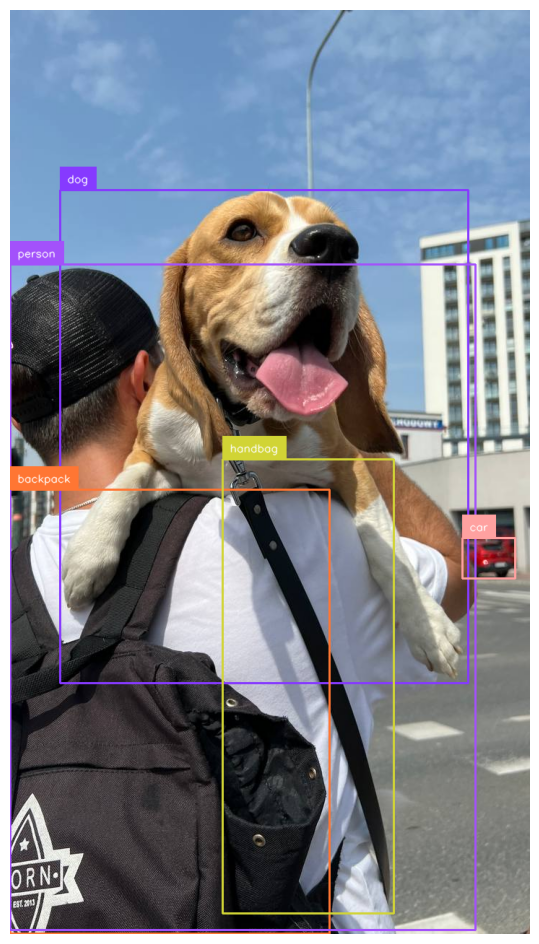

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/ilyes-talbi-ptwsp/futbol-players/dataset/9', 'yolov12')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to futbol-players-9 in yolov12:: 100%|██████████| 792/792 [00:00<00:00, 8984.17it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['0', '1', '2']

roboflow:
  workspace: ilyes-talbi-ptwsp
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/futbol-players-9/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.34M/5.34M [00:00<00:00, 96.0MB/s]


AMP: checks passed ✅


train: Scanning /content/futbol-players-9/train/labels... 341 images, 0 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<00:00, 1620.67it/s]

train: New cache created: /content/futbol-players-9/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/futbol-players-9/valid/labels... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<00:00, 1144.61it/s]

val: New cache created: /content/futbol-players-9/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/22 [00:00<?, ?it/s]Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
      1/100      5.06G      6.173      5.113      4.147        121        640: 100%|██████████| 22/22 [00:10<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         33        407          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.92G      5.598      4.261      3.731         98        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         33        407          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.97G      3.449      2.391      2.961         41        640: 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         33        407          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.88G      2.923      1.864      2.445         59        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         33        407          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.98G      2.575      1.592       2.15         92        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         33        407    0.00133    0.00279    0.00087   0.000251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.96G      2.419      1.514      2.017        117        640: 100%|██████████| 22/22 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         33        407    0.00134      0.013   0.000741    0.00015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.98G      2.295      1.391      1.911         55        640: 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         33        407      0.853      0.122      0.232     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.97G      2.256      1.345      1.867         82        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         33        407      0.742      0.324      0.384      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.97G      2.205      1.278      1.763        126        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         33        407      0.663      0.367      0.393      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.96G      2.117       1.24      1.739         75        640: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         33        407       0.87      0.533      0.593      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.01G      2.052      1.154      1.633         90        640: 100%|██████████| 22/22 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         33        407      0.953      0.555      0.638      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.94G      2.034      1.158      1.677         59        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         33        407      0.859      0.492      0.593      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.92G      2.002      1.116      1.607         54        640: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         33        407      0.964      0.552      0.709      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.92G      1.989       1.11      1.592         73        640: 100%|██████████| 22/22 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         33        407      0.924      0.585      0.728      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.94G      1.927       1.08      1.568         71        640: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         33        407      0.768      0.674      0.769      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.01G      1.958      1.064      1.553         99        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         33        407       0.81      0.665      0.766      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.03G      1.934      1.083       1.55         41        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         33        407       0.93      0.631       0.74      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.98G      1.905      1.044      1.541         41        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


                   all         33        407      0.753      0.679      0.729       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.95G      1.849      1.006      1.491        109        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         33        407      0.675      0.735      0.766      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.98G      1.878      1.024      1.486         33        640: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         33        407      0.871      0.685      0.774      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.92G      1.847     0.9981      1.454        122        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         33        407       0.88      0.676       0.77      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.92G      1.819     0.9732      1.431         55        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         33        407      0.869      0.757      0.816      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.02G      1.773     0.9489      1.406         63        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         33        407      0.911      0.705      0.812      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.97G      1.817     0.9695       1.44         55        640: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         33        407      0.747      0.738       0.76      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         5G      1.746     0.9311      1.388         99        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         33        407      0.884      0.804      0.845      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.95G      1.768     0.9153      1.396         64        640: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         33        407      0.923      0.766      0.824      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.98G      1.712     0.9048      1.373         79        640: 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         33        407      0.805      0.797      0.841      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.95G      1.747     0.9099      1.372         69        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         33        407      0.919      0.782      0.851      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.93G      1.691     0.8852      1.339         72        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         33        407      0.914      0.751      0.802      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.94G      1.674     0.8688      1.328        120        640: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         33        407      0.847      0.792      0.781      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         5G       1.68     0.8615      1.316        120        640: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         33        407      0.916      0.788      0.837      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.02G      1.654     0.8659      1.326         71        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         33        407      0.896      0.808      0.844       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         5G       1.68     0.8848      1.334        101        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         33        407      0.885       0.79      0.828      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.91G      1.639     0.8573      1.322        103        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         33        407      0.914      0.814      0.832      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         5G      1.676     0.8636      1.303        126        640: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         33        407      0.941      0.849      0.866      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.93G      1.647     0.8524      1.286         99        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         33        407      0.853      0.821      0.856      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.93G      1.653     0.8549      1.288         94        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         33        407      0.945       0.83      0.859      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.97G      1.645     0.8468      1.301        124        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         33        407      0.911      0.797      0.846      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.94G      1.612     0.8318      1.293        107        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         33        407      0.921      0.838      0.872      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.97G      1.634     0.8363      1.299         94        640: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         33        407      0.888      0.844      0.851      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.97G      1.607     0.8245      1.289         69        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         33        407      0.944      0.846      0.874       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.99G      1.603      0.822      1.288         68        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         33        407      0.957      0.863       0.88      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.04G      1.607     0.8243      1.275         94        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         33        407      0.962      0.796      0.873      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.97G      1.621     0.8281      1.296         87        640: 100%|██████████| 22/22 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         33        407      0.891      0.839      0.841      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.12G      1.618     0.8278      1.288         94        640: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         33        407      0.879      0.833      0.872      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.93G      1.588     0.8119      1.255         85        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         33        407      0.944      0.845      0.871       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.01G      1.575     0.7927      1.243         87        640: 100%|██████████| 22/22 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         33        407        0.9      0.835       0.86      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.93G      1.558     0.7887      1.227         61        640: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         33        407      0.887      0.838      0.871      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.97G      1.543     0.7829       1.23         74        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         33        407      0.931      0.854      0.872      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.96G      1.578      0.788      1.248         87        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         33        407      0.919      0.861      0.877      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.94G      1.563     0.7945      1.258         76        640: 100%|██████████| 22/22 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         33        407      0.928      0.788      0.861      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.95G      1.553      0.788      1.255         40        640: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         33        407      0.905      0.849       0.86      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.94G      1.541     0.7877      1.244         72        640: 100%|██████████| 22/22 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         33        407      0.882      0.835      0.882      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.97G      1.549     0.7717      1.216         74        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         33        407      0.916      0.812      0.852      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         5G      1.529     0.7749      1.216         53        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         33        407        0.9      0.841      0.866      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.97G      1.555       0.78      1.248         85        640: 100%|██████████| 22/22 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         33        407      0.878      0.835      0.877      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.94G      1.519     0.7695      1.215        101        640: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         33        407       0.94      0.838      0.896       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.95G      1.483     0.7546      1.195         95        640: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         33        407      0.941      0.821      0.861      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.96G       1.55      0.775      1.245         65        640: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         33        407      0.951      0.844      0.887      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.04G      1.511     0.7635       1.24        107        640: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         33        407      0.948      0.816      0.864      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.94G      1.484     0.7423      1.207        112        640: 100%|██████████| 22/22 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         33        407      0.918      0.835      0.882      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.94G      1.518     0.7734      1.225         84        640: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         33        407        0.9      0.861      0.891      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.94G      1.501     0.7532      1.225         98        640: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         33        407      0.895      0.855      0.887      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.92G      1.513     0.7523       1.22        134        640: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         33        407      0.928      0.859      0.895      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.91G      1.482     0.7421      1.204         92        640: 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         33        407      0.935      0.819      0.857      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.93G       1.49     0.7485      1.204         90        640: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         33        407       0.93      0.834      0.871      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.96G      1.492     0.7363        1.2        108        640: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         33        407      0.943      0.834      0.888      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.98G      1.438     0.7224      1.185        105        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         33        407      0.938      0.815      0.868       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.89G       1.46     0.7286      1.196         56        640: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         33        407      0.966      0.846      0.893      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.95G      1.496     0.7447      1.203        209        640: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         33        407      0.943      0.853      0.892      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.04G      1.494     0.7396      1.194        157        640: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         33        407       0.93       0.84      0.877      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         5G      1.478     0.7368      1.197         65        640: 100%|██████████| 22/22 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         33        407      0.961      0.822      0.894      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.98G      1.463      0.717      1.195         60        640: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         33        407      0.949      0.836      0.881      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.93G       1.46     0.7244      1.192         95        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         33        407      0.918      0.832      0.883      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.92G      1.461     0.7225      1.191         60        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         33        407      0.965      0.851      0.903      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.93G      1.438      0.715      1.192         59        640: 100%|██████████| 22/22 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         33        407      0.979      0.835      0.897      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.01G      1.464     0.7225      1.192         65        640: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         33        407      0.931      0.833      0.872      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.94G      1.419     0.7154      1.181        132        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         33        407      0.956      0.854      0.901      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.99G      1.472     0.7156      1.185         93        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         33        407      0.969      0.865      0.889       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.96G       1.43     0.7101      1.161         88        640: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         33        407      0.973       0.86      0.903      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.95G       1.42     0.7058      1.167         72        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         33        407      0.971      0.851      0.898      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.98G      1.422     0.7015      1.152        108        640: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         33        407      0.971      0.847      0.897      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.95G       1.42      0.696      1.162         63        640: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         33        407       0.97      0.845      0.902      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.97G      1.431     0.7082      1.182         65        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         33        407      0.965      0.843      0.893      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.92G      1.402     0.6909      1.158        132        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         33        407      0.956      0.836      0.883      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.95G       1.42     0.6951      1.163         71        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         33        407      0.965      0.849      0.891      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.95G      1.398     0.6862      1.146        111        640: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         33        407       0.96      0.852        0.9      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.97G      1.384     0.6807       1.15         63        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

                   all         33        407      0.979      0.831      0.895      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.94G      1.435     0.7007      1.172        114        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         33        407      0.966      0.863      0.902      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.94G      1.385     0.6839      1.164         72        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         33        407      0.968      0.854      0.905      0.502


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.95G       1.36     0.6898      1.212         50        640: 100%|██████████| 22/22 [00:09<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         33        407       0.93      0.863      0.905        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.96G      1.372     0.6765      1.213         57        640: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         33        407      0.949      0.864      0.906      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.95G      1.368     0.6718      1.226         32        640: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         33        407      0.948      0.865      0.904      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.94G      1.353     0.6634      1.209         57        640: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         33        407      0.978      0.859      0.907      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.95G      1.326     0.6573      1.204         50        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         33        407      0.968      0.849      0.907      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.96G       1.34     0.6576      1.211         55        640: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         33        407      0.984      0.849      0.906      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.95G      1.326     0.6499      1.172         50        640: 100%|██████████| 22/22 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         33        407      0.977      0.851      0.903      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.94G      1.319     0.6545      1.201         53        640: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         33        407      0.966      0.852      0.903      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.95G      1.349     0.6598      1.207         63        640: 100%|██████████| 22/22 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         33        407       0.97      0.854      0.907      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.96G      1.333     0.6641      1.214         59        640: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         33        407      0.967      0.853      0.907      0.498



100 epochs completed in 0.274 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 352 layers, 9,232,041 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


                   all         33        407      0.966      0.863      0.902      0.512
                     0         33        359      0.965      0.969      0.991      0.608
                     1         20         20      0.934       0.95      0.959       0.66
                     2         28         28          1      0.668      0.755      0.268
Speed: 0.2ms preprocess, 6.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   PR_curve.png		train_batch1.jpg
confusion_matrix_normalized.png			   R_curve.png		train_batch2.jpg
confusion_matrix.png				   results.csv		val_batch0_labels.jpg
events.out.tfevents.1740988149.59ac8799ef78.350.0  results.png		val_batch0_pred.jpg
F1_curve.png					   train_batch0.jpg	val_batch1_labels.jpg
labels_correlogram.jpg				   train_batch1980.jpg	val_batch1_pred.jpg
labels.jpg					   train_batch1981.jpg	weights
P_curve.png					   train_batch1982.jpg


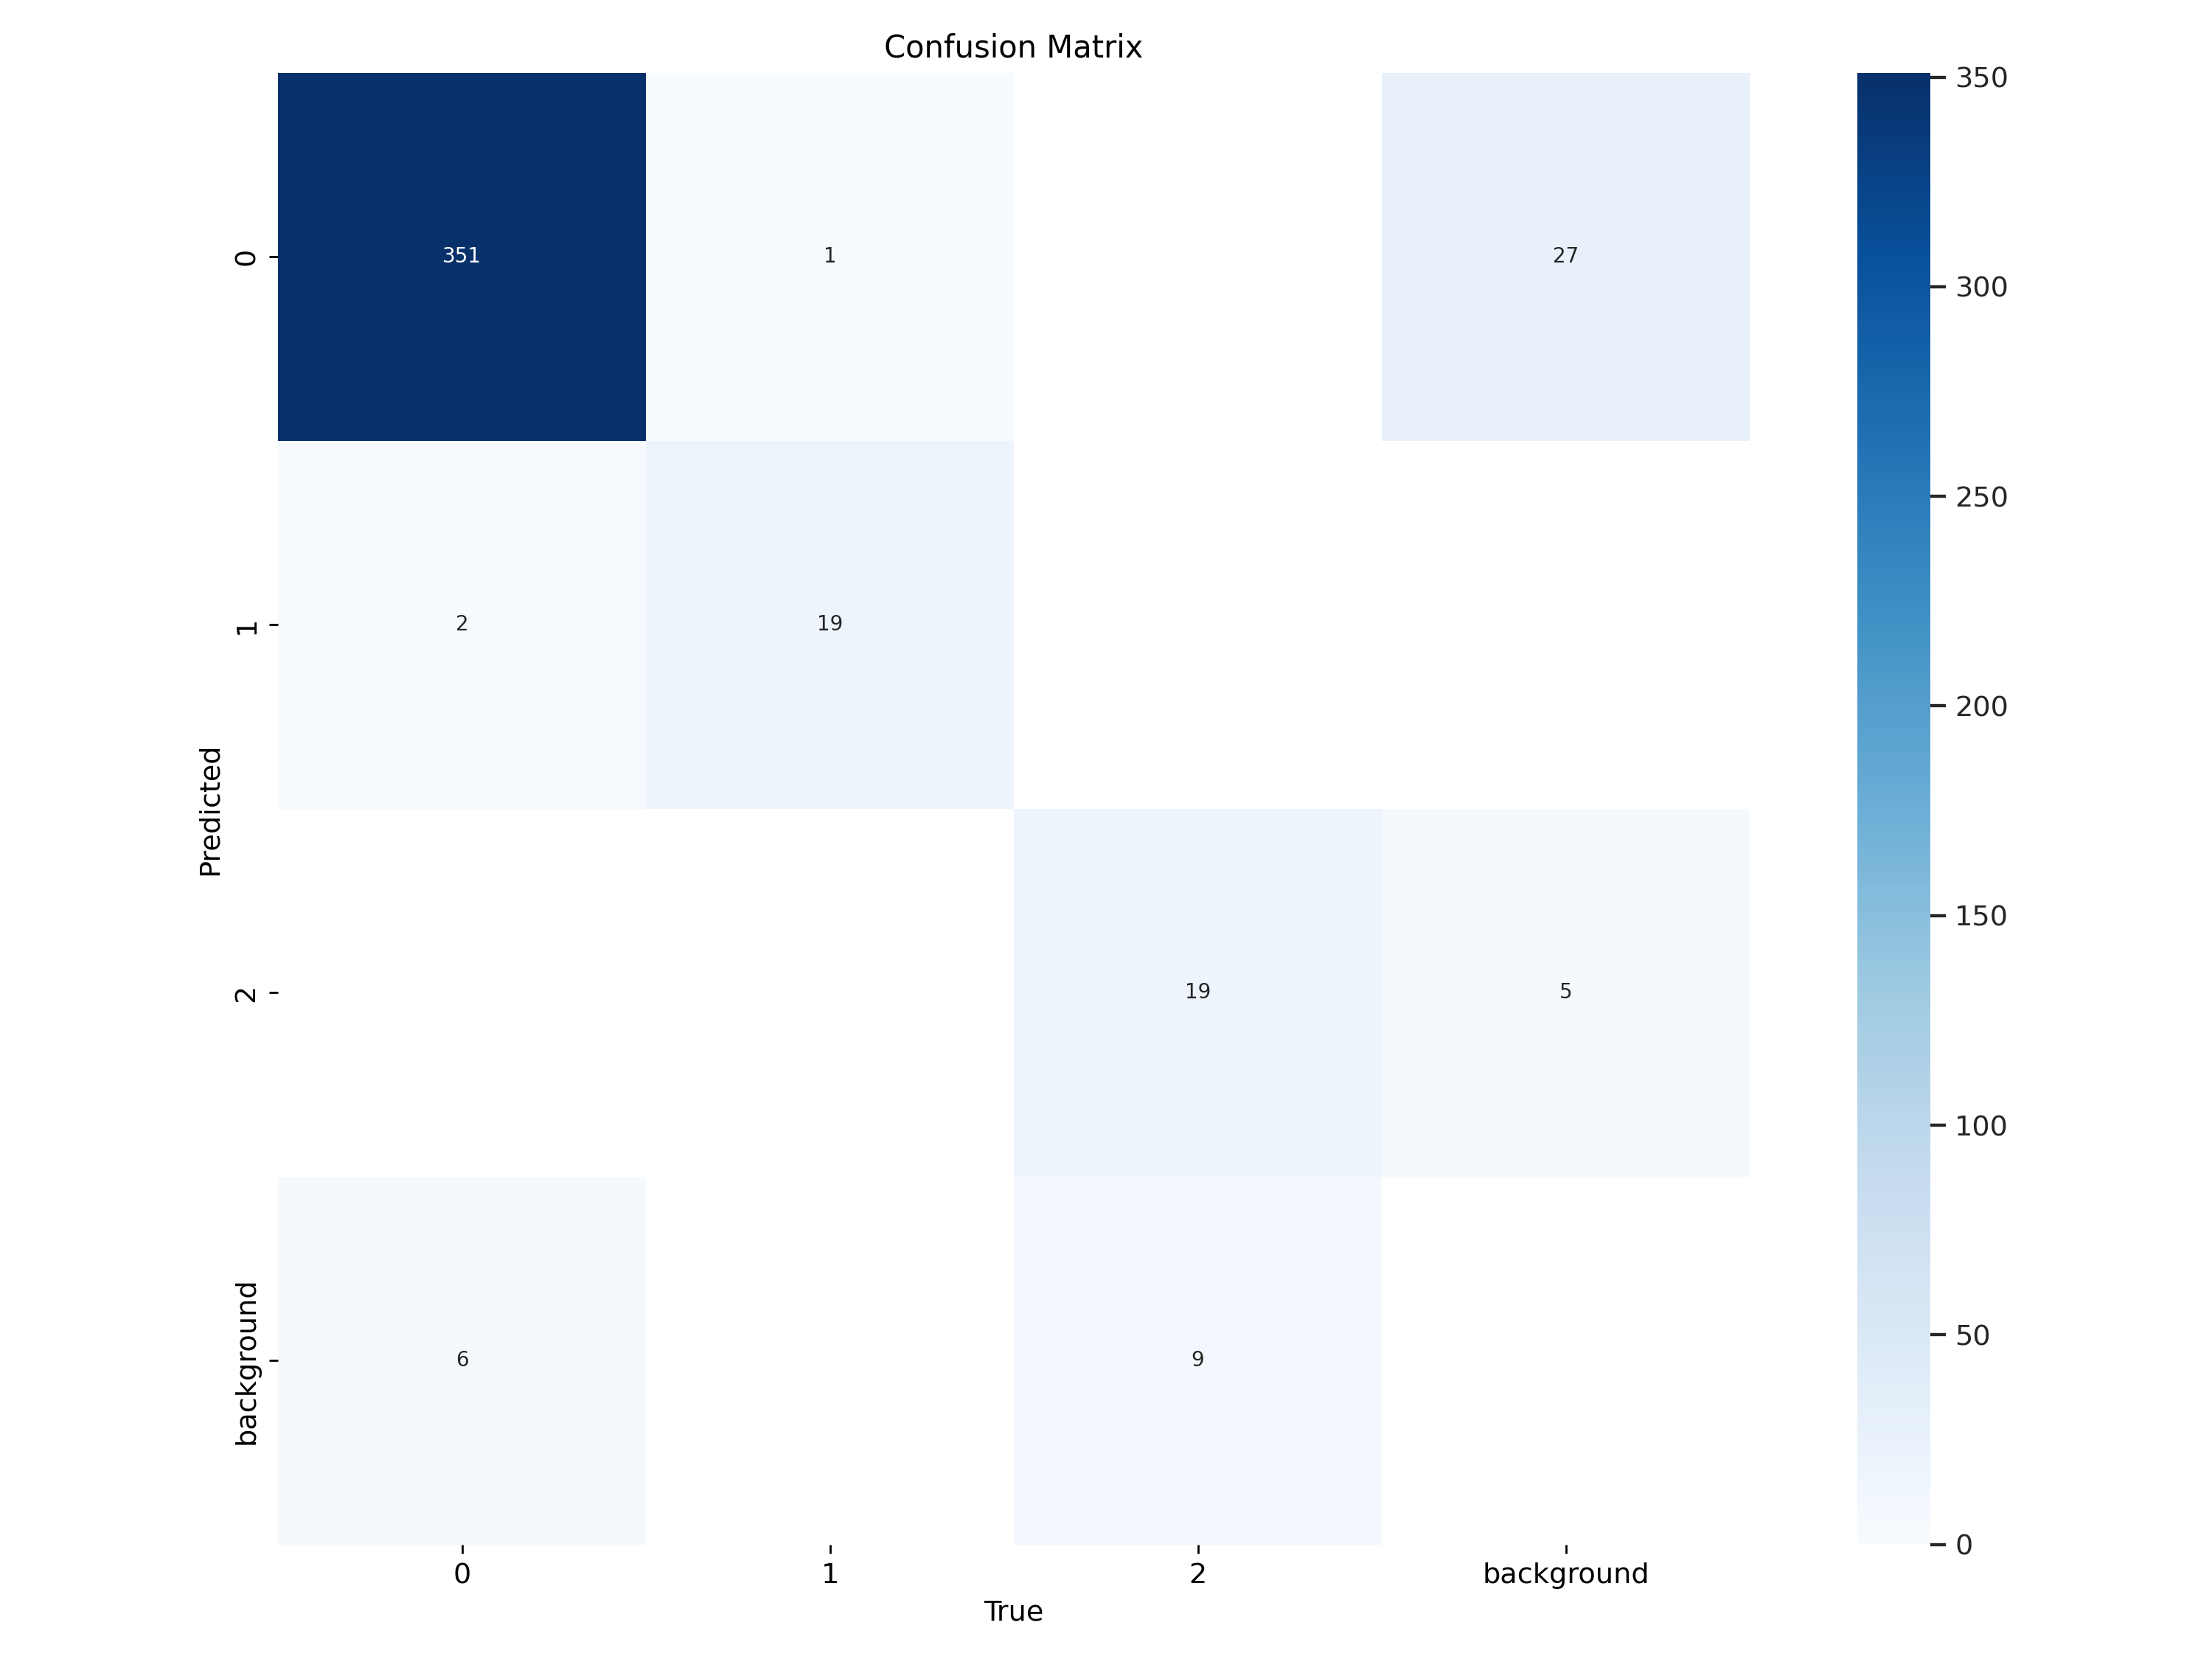

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

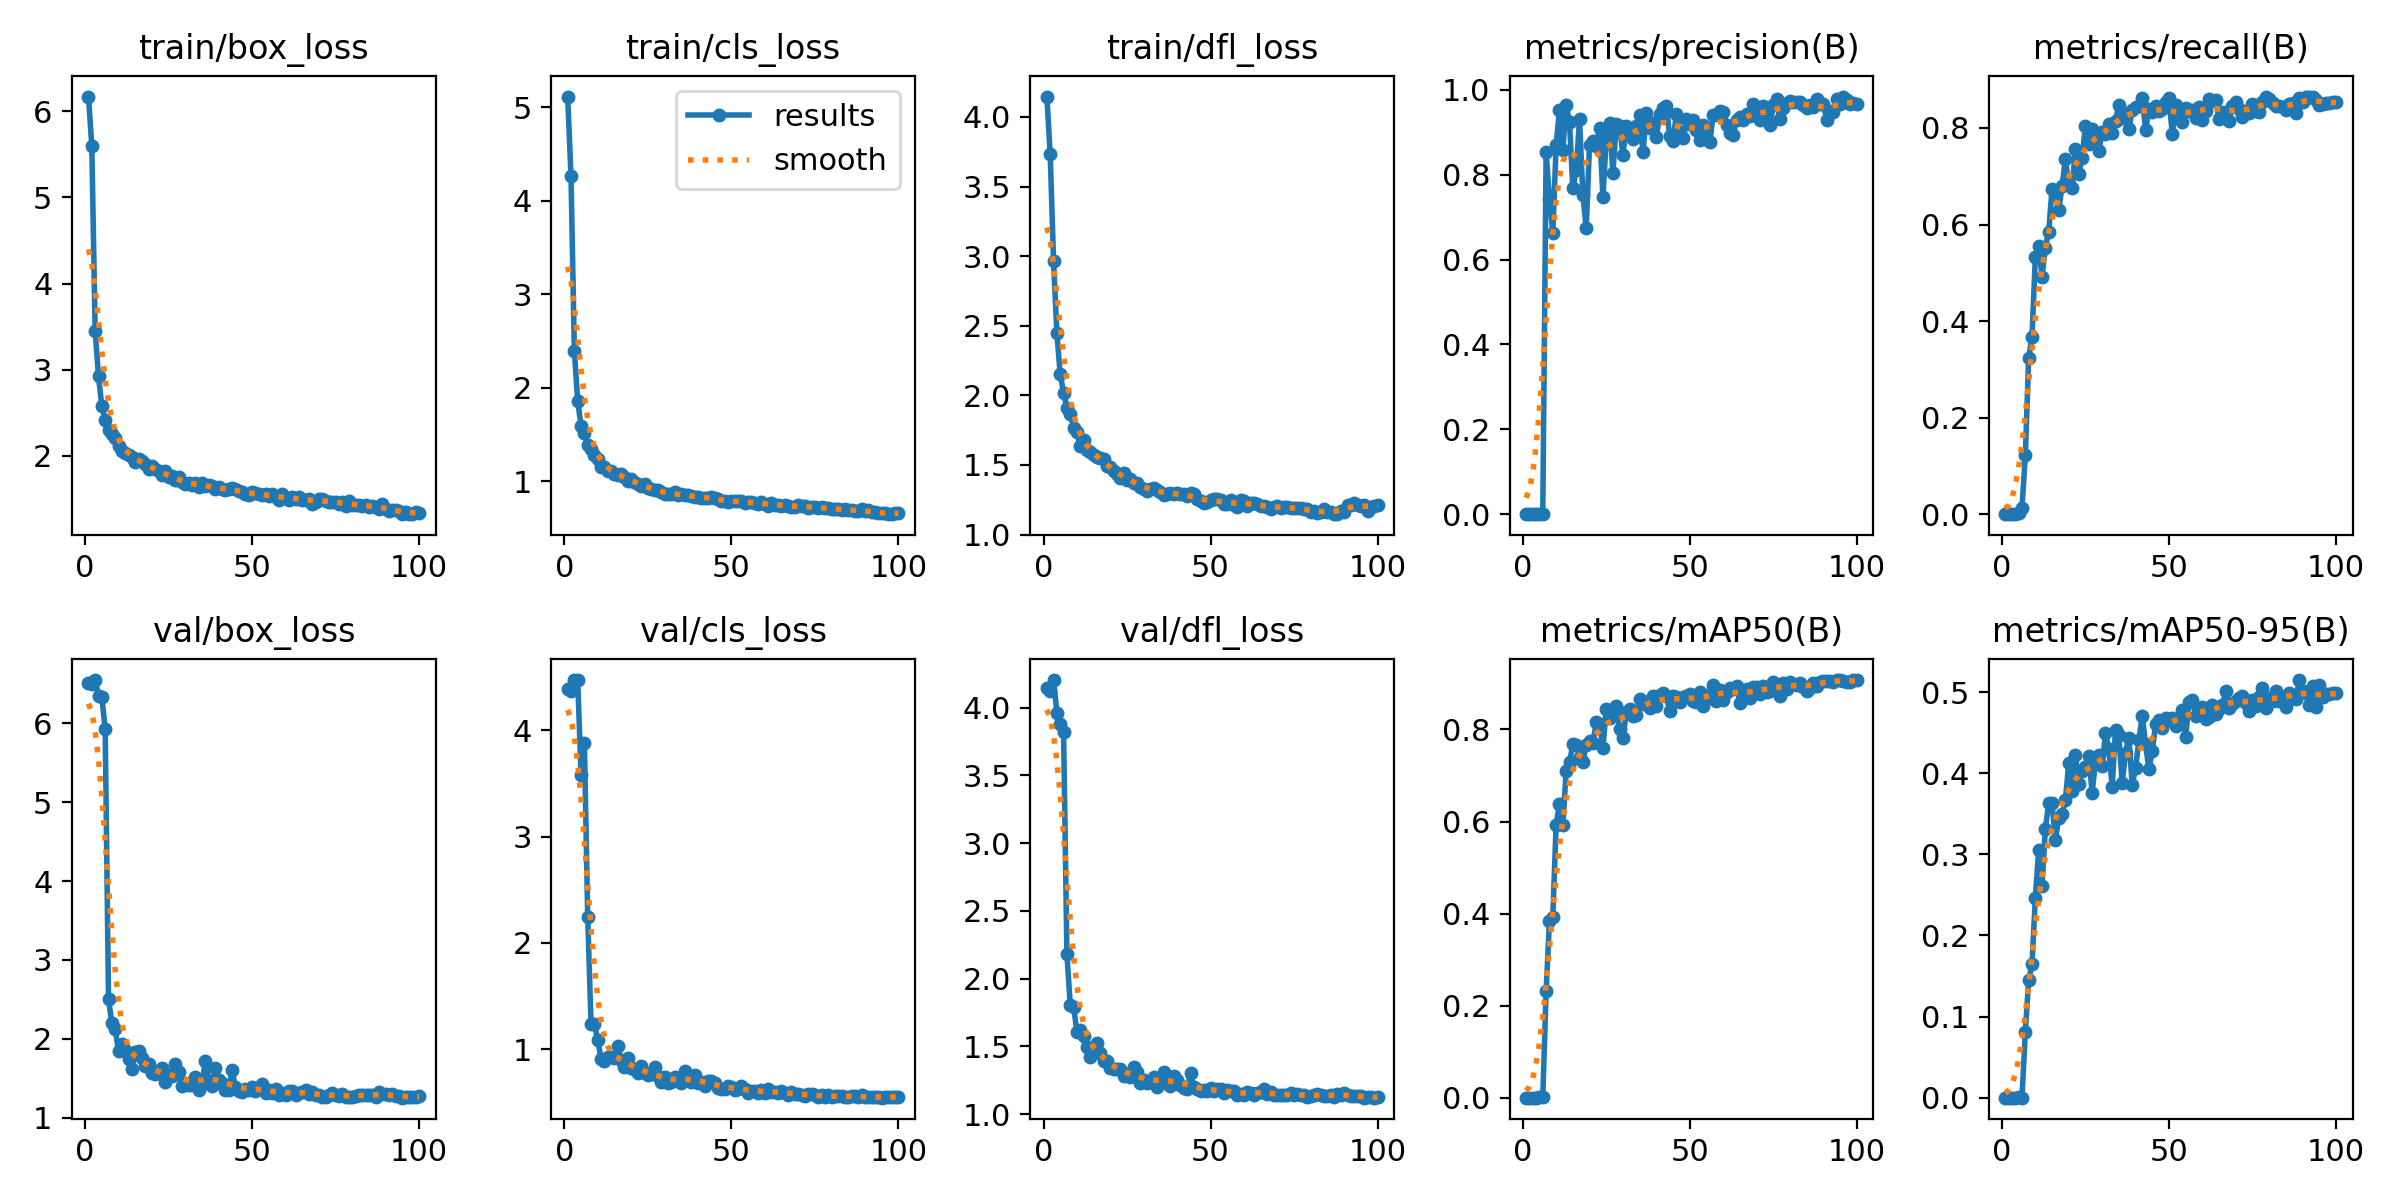

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['0', '1', '2']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.4937005023693589
mAP 50 0.8618640438588026
mAP 75 0.6487115112843289


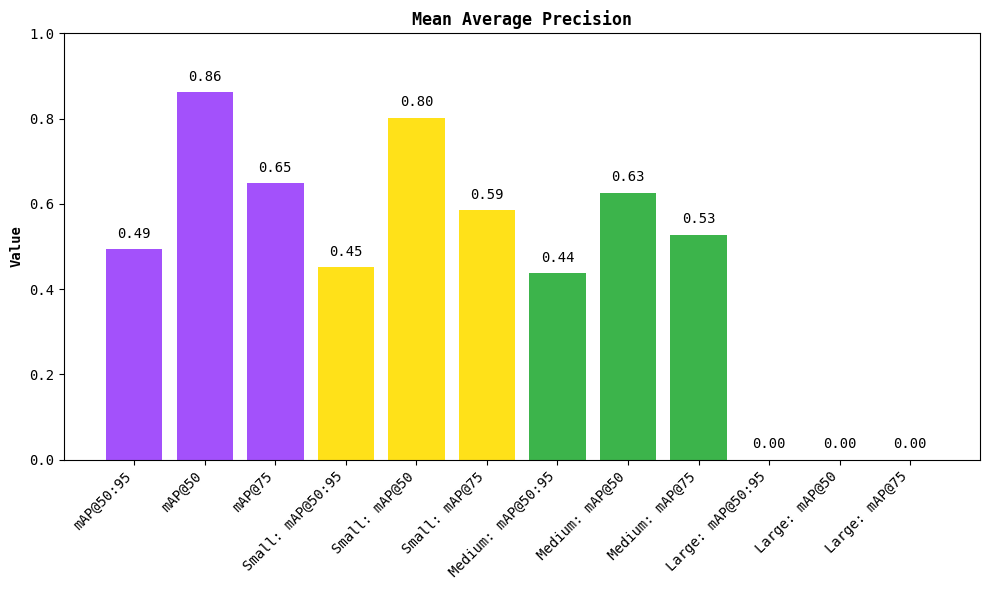

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)